<a href="https://colab.research.google.com/github/ljzier/ST-554-repo/blob/main/Task3/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Cross-Validation Algorithm (Task 3)

This task involves coding up a cross-validation algorithm to evaluate multiple linear regression models in the
time series setting.

# Load and clean the dataset for task 3.

In [1]:
# Install the ucimlrepo package available at the UC Irvine Repository
!pip install ucimlrepo

import ucimlrepo as uci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
air_quality = uci.fetch_ucirepo(id=360)
# view data set
air_quality = air_quality.data.features
air_quality.head()
air_quality.info()
air_quality.describe()
air_quality.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


,0
Date,0
Time,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0


Remove any observations where the C6H6(GT), CO(GT), T, RH, or AH are -200 as these represent missing
values.

In [3]:
print((air_quality[["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]] == -200).sum())

# Create a copy to avoid modifying the original 'air_quality' directly
air_quality_temp = air_quality.copy()

# Replace -200 with NaN in the relevant columns
cols_to_clean = ["C6H6(GT)", "CO(GT)", "T", "RH", "AH"]
air_quality_temp[cols_to_clean] = air_quality_temp[cols_to_clean].replace(-200, np.nan)

# Drop rows where any of the specified columns have NaN values
air_quality_clean = air_quality_temp.dropna(subset=cols_to_clean).copy()
air_quality_clean.info()


C6H6(GT)     366
CO(GT)      1683
T            366
RH           366
AH           366
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7344 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7344 non-null   object 
 1   Time           7344 non-null   object 
 2   CO(GT)         7344 non-null   float64
 3   PT08.S1(CO)    7344 non-null   int64  
 4   NMHC(GT)       7344 non-null   int64  
 5   C6H6(GT)       7344 non-null   float64
 6   PT08.S2(NMHC)  7344 non-null   int64  
 7   NOx(GT)        7344 non-null   int64  
 8   PT08.S3(NOx)   7344 non-null   int64  
 9   NO2(GT)        7344 non-null   int64  
 10  PT08.S4(NO2)   7344 non-null   int64  
 11  PT08.S5(O3)    7344 non-null   int64  
 12  T              7344 non-null   float64
 13  RH             7344 non-null   float64
 14  AH             7344 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage

 Create a new version of the data with the Date, C6H6(GT), CO(GT), T, RH, and AH

– The values of the five variables above should be their average across the given Date.


In [36]:
# Removing any columns that aren't "Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"
air_quality_clean = air_quality_clean[["Date", "C6H6(GT)", "CO(GT)", "T", "RH", "AH"]]

# converting the date from an object to a date
air_quality_clean["Date"] = pd.to_datetime(air_quality_clean["Date"])

# Averaging the variables by date
air_data = air_quality_clean.groupby("Date").mean()

# Creating a day variable
air_data["Day"] = air_data.index.day
print(air_data["Day"])
air_data.head()

Date
2004-03-10    10
2004-03-11    11
2004-03-12    12
2004-03-13    13
2004-03-14    14
              ..
2005-03-31    31
2005-04-01     1
2005-04-02     2
2005-04-03     3
2005-04-04     4
Name: Day, Length: 347, dtype: int32


,C6H6(GT),CO(GT),T,RH,AH,Day
Date,,,,,,
2004-03-10,8.450000,1.966667,12.033333,54.900000,0.765633,10
2004-03-11,8.269565,2.239130,9.826087,64.230435,0.777039,11
2004-03-12,12.177273,2.804545,11.618182,50.190909,0.665164,12
2004-03-13,11.121739,2.695652,13.121739,50.682609,0.733013,13
2004-03-14,9.830435,2.469565,16.182609,48.317391,0.849209,14


We will be considering two models.

The first is an SLR model using CO(GT) to predict C6H6(GT)

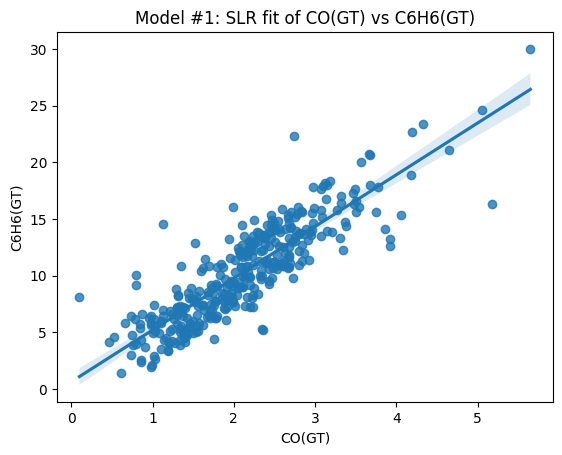

The intercept is  0.644770948344199
The coefficient is  [4.56536116]


In [5]:
# SLR

# reshaping x valley into a column instead of a 1 dimensional array
# print(air_data[["CO(GT)"]].shape)
# print(air_data["CO(GT)"].values.reshape(-1,1).shape)

# Plotting CO(GT) vs C6H6(GT)
sns.regplot(x=air_data["CO(GT)"],y=air_data["C6H6(GT)"])
plt.xlabel("CO(GT)")
plt.ylabel("C6H6(GT)")
plt.title("Model #1: SLR fit of CO(GT) vs C6H6(GT)")
plt.show()

# using the Linear model function from sklearn module to fit the SLR
# creating a regression object
air_slr = linear_model.LinearRegression()
air_slr.fit(
    air_data[["CO(GT)"]], #this is a data frame because of the [[ ]]
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_slr.intercept_)
print( "The coefficient is ", air_slr.coef_)


The second model we are considering is an MLR model using CO(GT), T, RH, and AH to predict C6H6(GT).


In [6]:
# Using using CO(GT), T, RH, and AH to predict C6H6(GT)

# using the Linear model function from sklearn module to fit the MLR
air_mlr = linear_model.LinearRegression()
air_mlr.fit(
    air_data[["CO(GT)", "T", "RH", "AH"]],
    air_data["C6H6(GT)"]
)

print( "The intercept is ", air_mlr.intercept_)
print( "The coefficients are ", air_mlr.coef_)

The intercept is  -1.8377694729981364
The coefficients are  [ 4.77080433  0.11973259 -0.01620259  0.68866811]


## Cross Validation ##

We want to see how well these two competing models do at predicting, but since we are doing time data, close days will be correlated. Instead we'll train the model and then judge it.

1. Use the first 250 days of data to fit the model. Use that model to predict the 251st day. Calculate the
MSE for that prediction.
2. Use the first 251 days of data to fit the model. Use that model to predict the 252nd day. Calculate
the MSE for that prediction.
3. Repeat until you predict for the last day.
4. Sum up the MSE values to get an overall MSE for the model!

In [42]:
# Define our X and y
X_mlr = ["CO(GT)", "T", "RH", "AH"]
X_slr = ["CO(GT)"]
y = ["C6H6(GT)"]

# starting training size value
train_st = 250

#initializing result dataframe
model_comp = []

# using a for loop to iterate through the process of increasing the training size
# and predicting until the end of the data is reached

for day in range(train_st, len(air_data)):

    # training set up to but not including test day
    X_train_mlr = air_data.iloc[:day][X_mlr]
    X_train_slr = air_data.iloc[:day][X_slr]
    y_train = air_data.iloc[:day][y]

    # the next day
    X_test_mlr = air_data.iloc[day:day+1][X_mlr]
    X_test_slr = air_data.iloc[day:day+1][X_slr]
    y_test = air_data.iloc[day:day+1][y]

    #fit the models
    slr_fit = linear_model.LinearRegression().fit(X_train_slr, y_train)
    mlr_fit = linear_model.LinearRegression().fit(X_train_mlr, y_train)

    #predict the next value
    slr_pred = slr_fit.predict(X_test_slr)
    mlr_pred = mlr_fit.predict(X_test_mlr)

    #calculate MSE
    mse_slr = mean_squared_error(y_test, slr_pred)
    mse_mlr = mean_squared_error(y_test, mlr_pred)

    model_comp.append([
        day + 1,             #actual day number
        day,                 # training size
        mse_slr, mse_mlr])   # mse's

# Convert the list of results to a dataframe
df_results = pd.DataFrame(model_comp, columns=['day', 'train_size', 'mse_slr', 'mse_mlr'])

# Print the dataframe with individual MSEs
print(df_results)

# Print the sum of MSEs
print(df_results.sum())

    day  train_size    mse_slr    mse_mlr
0   251         250  10.669616   1.632153
1   252         251  22.555731   9.899428
2   253         252  79.916651  61.127787
3   254         253  34.133677  21.965161
4   255         254   8.167241   0.769942
..  ...         ...        ...        ...
92  343         342   3.268224   2.403935
93  344         343   4.962906   3.108343
94  345         344   4.206294   2.134818
95  346         345   2.416153   1.964801
96  347         346   1.326674   0.987894

[97 rows x 4 columns]
day           29003.000000
train_size    28906.000000
mse_slr         718.081029
mse_mlr         494.342222
dtype: float64


Write a function to do the above given a particular X, y, and starting Date or Day.

Some guidelines and helpful hints:

• First write a function to get the MSE for one step of the above.

– Have this function take in a data frame of predictors X (this will be used in the .fit() method
of a LinearRegression() object), a 1D response y, and a day argument. The day argument will
correspond to the last day or date that should be used in the training data.

– Use the day argument to subset the data into a training X and y and a testing X and y. Have your
training set include all days up to and including day and your test set just include the day + 1 row.

– Do the model fitting on the training and predict on the test set. Return the mean squared error.


In [56]:
# defining a function to do this calculation on a given X, y and starting day

# function to get the MSE for 1 day
def get_mse(X_df, response_y, test_index):
   """
   This function takes in a data frame of predictors X and a 1D response y as well
   as a starting day which will be correspond to the last day in the training data.
   It will return the MSE.
   """
   # creating the train and test datasets
   X_train = X_df.iloc[:test_index]
   y_train= y_response.iloc[:test_index]
   X_test = X_df[test_index:test_index+1]
   y_test = y_response.iloc[test_index:test_index+1]

   # fit the model to the training set
   model_fit = linear_model.LinearRegression().fit(X_train, y_train)

   #predict the next value using the test set
   y_pred = model_fit.predict(X_test)

   #calculate the MSE
   model_mse = mean_squared_error(y_test, y_pred)

   #return the MSE
   return model_mse


 Now write a function to obtain the CV value over all the days (other than the initial training block of 250 days)

– Have this function take in X, y (both as above), and a day argument.

– Initialize an MSE value at 0

– Use a loop to iterate from the day (here day 250, but this leaves it up to the user to decide) to the final day in the data set minus 1 (use code to determine this rather than hardcoding a final
day)

∗ Within the loop, use the helper function defined previously along with augmented assignmentto add the MSE as you go

– Return the MSE

In [57]:
# function to obtain our CV value over all the days AFTER the initial day

def get_CV_value(X_df, y_response, initial_train_sz):
    """
    This function will obtain our MSE values for our 1- step ahead predictions
    """
    #initializing the mse
    total_mse=0

    # by range and going to len(X_df) I'm stopping before the last day
    # appending to total_mse as I go
    for i in range(initial_train_sz, len(X_df)):
        total_mse += get_mse(X_df, y_response, i)

    return total_mse

Now run your function using the SLR model. Repeat using the MLR model. Discuss the MSE values you
see and which model you prefer. Then fit the ‘best’ model to the entire data set.


In [68]:
# Running our function on the SLR model and our MLR model

# Define our X and y using the original data set
X_mlr = air_data[["CO(GT)", "T", "RH", "AH"]]
X_slr = air_data[["CO(GT)"]]
y_response = air_data["C6H6(GT)"]

# Prompting the user for day value for initial training size
print(f"Enter the day value for initial training size. For this data set this needs to be between (1 and {len(air_data) - 1}): ")
day = int(input())

# Input validation loop
while not (1 <= day < len(air_data)):
    print(f"Try again. Please enter a day value between 1 and {len(air_data) - 1}.")
    day = int(input())

#Getting the CV value for the SLR function
slr_cv = get_CV_value(X_slr, y_response, day)

# Getting the CV value for the MLR function
mlr_cv = get_CV_value(X_mlr, y_response, day)

print("The CV value for the SLR model is: ", slr_cv)
print("The CV value for the MLR model is: ", mlr_cv)

Enter the day value for initial training size. For this data set this needs to be between (1 and 346): 
346
The CV value for the SLR model is:  1.3266735314572087
The CV value for the MLR model is:  0.987893904778381
